# Harry Potter Books NLP Analysis 


***Author: ANNA CHIARA DI MARCO***  


### Table of Contents   
[1. Data and Preprocessing](#preprocessing)     
[2. Analysis](#analysis)       
[2.1 Word Embeddings](#word-embeddings)    
[2.2 Analysis of most important terms: TF-IDF-TFIDF](#tfidf)    
[2.3 Pointwise Mutual Information (PMI)](#PMI)   
[2.4 Language Generation using HP Books](#language-generation)  
[2.5 Topic Modeling](#topic)    
[2.5.1 LDA Topic Modeling](#LDA)  
[2.5.2 Dynamic Topic Modeling](#dynamic)  
	[2.6 Matrix Factorization](#matrix)  
	[2.7 Clustering](#clustering)  
[3. Visualization](#visualization)  
	[3.1 Word Embeddings Visualization](#word-visua)  
	[3.2 TSNE Word2Vec Visualization](#tsne)  
	[3.3 Word2Vec Book1 Book7 Visualization](#book1book7)  
	[3.4 PCA Words Embeddings Visualization](#pcavisua)  
	[3.5 Unigrams TF-IDF-TFIDF Visualization scaled by TF](#tf-scaled)  
	[3.6 Bigrams TF-IDF-TFIDF Visualization scaled by TF](#bigrams-scaled)  
	[3.7 Harry - Ron - Hermione Occurrencies  Visualization](#harry-ron-co-occ)  
	[3.8 Topic Modeling Visualization](#topic-visua)  
	[3.9 Clusering Visualization](#clust-visua)  

In [1]:
'''Import the relevant libraries for the analysis'''
import pandas as pd
import numpy as np
import spacy
import nltk
import gensim
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.max_length = 2000000
import re

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF  
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict 

from gensim import models
from gensim.models import Phrases
from gensim.models import phrases
from gensim.models.phrases import Phraser
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import ldaseqmodel
from gensim.matutils import hellinger

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

import seaborn
import seaborn as sns
import time 
import multiprocessing 
import pyLDAvis
import pyLDAvis.gensim

import os 
# set the base directory 
b_dir = 'C:/Users/anna9/Desktop/.../'

## 1. Data and Preprocessing
<a id="preprocessing"></a> 

###### Description of the content and type of the dataset

For this project I downloaded the 7 Harry Potter Books in .txt format from  http://www.glozman.com/textpages.html webiste. In the end, I had 7 .txt files each containg one Harry Potter book. 

##### PREPROCESSING 

The first preprocessing step was to read each of the txt files, transform it into a unique string and then split it into sentences (first splitting the documents, and then applying nlp .sents method).
  Then I have used RegEx to remove any number and special character appearing in the text. After that, I took the sentences and I have expanded all the contractions. Once the sentences were expanded I have tokenized the senteces, put them into lower case and retreived only the lemmas form of the tokens. I have also removed punctuation,retrieved only the content words ('NOUN','VERB','PROPN', 'ADJ','ADV') and removed stopwords. This allows to significantly reduce noise and retreive only the informative part of the text.
  I have also created an 'Instances' object which simply contains the grouped tokens for each sentence. 
Lastly, I have created a DataFrame contaning the book number, the tokens and the instances.   
  The initial input were .txt files whereas the output is a DataFrame containing the tokenized sentences and the instances. The length of the final instances is smaller than the number of original sentences as there have been a noise reduction.




| Book | Length Original Text | N^ Original Senteces | N^ Preprocesses Sentences  
| --- | --- | --- | --- | 
| 1 | 442066 | 7542 | 6647 |
| 2 | 489397 | 7931 | 6837 |
| 3 | 612445 | 10792 | 9345 |
| 4 | 1106719 | 17804 | 15609 |
| 5 | 1481713 | 21609 | 18664 |
| 6 | 984950 | 13939 | 12309 |
| 7 | 1132501 | 16926 | 14971 |

In [2]:
'''Defining functions to perform preprocessing'''

def clean_documents(raw_documents):
    '''
    Remove numbers and any special character from sentences
    '''
    documents = []
    numb = re.compile('[0-9]') #Removing numbers 
    special_cha = re.compile("[-+]?[^A-Za-z0-9 ']+") #Removing any special character 
    for sentence in raw_documents:
        cleaned_text = re.sub(numb,'',sentence)
        cleaned_text = re.sub(special_cha,'',cleaned_text)
        documents.append(cleaned_text.lower())
    return documents

def tokenizer(documents):
    '''
     Tokenize the documents 
     Put the text into lower case and retreive only the lemmas form of the tokens
     Removing punctuation 
     Retrieve only the content words (Noun,Verb,Propn,Adj,Adv) of the textbook
     Remove stopwords
     Remove empty tokens
    '''
    text = [[token.lemma_.lower() for token in nlp(sentence) 
                 if token.pos_ is not 'PUNCT'
                 and token.pos_ in {'NOUN','VERB','PROPN', 'ADJ','ADV'} 
                 and not token.is_stop] for sentence in documents]
    text = [token for token in text if token!=[]]
    return(text)

def Instances(text):
    '''
    Creating instances = put the tokens for each sentence together in a lisst
    Otput = list containing clean and preprocessed sentences
    '''
    instances=[]
    for sentence in text:
        seperator = ' '
        sent = (seperator.join(sentence))
        instances.append(sent)
    if instances !='':
        return(instances)

In [3]:
'''
Creating a dictionary with the most frequent english contractions from 
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
''' 

contraction_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

contr = re.compile('(%s)' % '|'.join(contraction_dict.keys()))

def expandContractions(text, contr=contr):
    '''
    Expanding contractions in the text 
    Takes a list of sentences and input and returns a list of expanded sentences 
    '''
    l = []
    for sentence in text:
        def replace(match):
            return contraction_dict[match.group(0)]
        sent = contr.sub(replace, sentence)
        l.append(sent)
    return l


In [4]:
'''
Creating a DataFrame with all the 7 HP Books. The DataFrame will contain the Book number, the tokenized sentences and instances
'''
corpustot = pd.DataFrame() #Initializing the final corpus as an empty DataFrame 
bookn = [1,2,3,4,5,6,7]
for book in bookn:
    file = open(os.path.join(b_dir) + "HP%s.txt" %book, "r",encoding="cp437") 
    text = file.read() #Open the book .txt file as a unique string 
    clean_text = text.rstrip()
    clean_text = clean_text.replace("\n", " ") #Remove the \n symbols
    #print(clean_text)

    sent = [str(sent) for sent in nlp(clean_text).sents] #Split the whole text into sentences 
    #print(len(sent))
    #print(sent)

    clean_sent = clean_documents(sent) #Apply clean_document function to the sentences 
    clean_sent = expandContractions(clean_sent) #Apply expandContraction function to expand text contractions 
    #print(clean_sent)
    
    tokens  =  tokenizer(clean_sent) #Tokenize the sentences and retrieve only relevant tokens 
    instances = Instances(tokens) #Form the instances back
    #print(tokens)
    #print(instances)
    
    data = {'Book': ['Harry Potter %s' %book for i in tokens], 
        'Tokens': [token for token in tokens],
        'Instances':[inst for inst in instances]}
    df = pd.DataFrame.from_dict(data)
    corpustot = corpustot.append(df)
    
corpustot.head()

,Book,Tokens,Instances
0,Harry Potter 1,"[harry, potter, sorcerer, stone, mr, mrs, durs...",harry potter sorcerer stone mr mrs dursley num...
1,Harry Potter 1,"[people, expect, involve, strange, mysterious,...",people expect involve strange mysterious hold ...
2,Harry Potter 1,"[mr, dursley, director, firm, call, grunning, ...",mr dursley director firm call grunning drill
3,Harry Potter 1,"[big, beefy, man, hardly, neck, large, mustache]",big beefy man hardly neck large mustache
4,Harry Potter 1,"[mrs, dursley, thin, blonde, nearly, usual, ne...",mrs dursley thin blonde nearly usual neck come...


In [5]:
corpustot.info()
corpustot = corpustot.reset_index(drop=True)
corpustot.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84382 entries, 0 to 14970
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Book       84382 non-null  object
 1   Tokens     84382 non-null  object
 2   Instances  84382 non-null  object
dtypes: object(3)
memory usage: 2.6+ MB


,Book,Tokens,Instances
84377,Harry Potter 7,"[harry, hand, raise, farewell]",harry hand raise farewell
84378,Harry Potter 7,"[alright, murmur, ginny]",alright murmur ginny
84379,Harry Potter 7,"[harry, look, dat, lower, hand, absentmindedly...",harry look dat lower hand absentmindedly touch...
84380,Harry Potter 7,[know],know
84381,Harry Potter 7,"[scar, pain, harry, year]",scar pain harry year


## 2. Analysis
<a id="analysis"></a>

###### Description of the research questions

Investigate the content of Harry Potter Books by analyzing their text. The research aims at giving a general words and topics analysis for the whole saga. In particular it will put a focus on the change in the characters co-occurrences along the books, and at understanding the dynamics of three main topics between the first and the last book. 

 - What are the most similar words to a given based on HP corpus?
 - What are the most frequent words-bigrams in HP?
 - Does the Harry-Ron/Harry-Hermione/Hermione-Ron occurence frequency changes along the books?
 - What is the PMI measure?
 - Are there any relevant distinct topics in HP?
 - What is the dynamic of some topics along the different books?

### 2.1- WORDS EMBEDDINGS
<a id="word-embeddings"></a> 

In [74]:
'''Create dense word embeddings and investigate the similarities among different words in the Harry Potter Saga
        These word embeddings are initially performed on the whole corpus without distinction between the different books.
        Then there are two word embeddings for Book1 and Book7 and we look at the changes in the most similar 
        terms for some words they share'''

toklist = corpustot['Tokens'].to_list() #List of the Tokens

#To perform a more accurate anlysis consider the text keeping the msot relevant bigrams 
phrases = Phrases(toklist) 
bigram = Phraser(phrases) 
bigrams = list(bigram[toklist]) 
#print(len(big))

In [79]:
# TRAIN THE WORD EMBEDDINGS MODEL
w2v_model = Word2Vec(size = 300,  
                     window = 15, 
                     sample = 0.00001, 
                     iter = 1000,  
                     negative = 5 , 
                     min_count = 100,
                     workers = -1,
                     hs = 0)

w2v_model.build_vocab(bigrams) 
w2v_model.train(bigrams, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(0, 0)

In [80]:
w2v_model.wv.most_similar(positive=["harry"])

[('fred_george', 0.17440195381641388),
 ('lord_voldemort', 0.16019998490810394),
 ('secret', 0.15815281867980957),
 ('small', 0.14897823333740234),
 ('different', 0.13917364180088043),
 ('burst', 0.1386541724205017),
 ('whisper', 0.13846944272518158),
 ('figure', 0.13624919950962067),
 ('aunt_petunia', 0.13433651626110077),
 ('wake', 0.13349352777004242)]

In [82]:
w2v_model.wv.doesnt_match(('harry hermione voldemort ron neville'.split()))

'ron'

In [83]:
w2v_model.wv.doesnt_match('harry hermione ron'.split())

'ron'

In [84]:
w2v_model.wv.most_similar_to_given('harry', ['snape', 'gryffindor','hermione'])

'hermione'

In [85]:
def similarities (word1, word2, word3):
    '''
    Define a function that gives us the related word  
    '''
    similarities = w2v_model.wv.most_similar(
        positive=[word1, word2],
        negative=[word3]
    )
    word4 = similarities[0][0]
    print('{word1} is related to {word2}, as {word3} is related to {word4}'.format(**locals()))
    
similarities('hermione', 'read', 'harry')

hermione is related to read, as harry is related to hour


In [15]:
'''
Create word embeddings for the tokens of book1 and book7 and look at the differences in most similar words for qrods they share 
''' 
toklist_1 = corpustot[corpustot['Book']=='Harry Potter 1']['Tokens'].to_list()
phrases_1 = Phrases(toklist_1) 
bigram_1 = Phraser(phrases_1) 
bigrams_1 = list(bigram[toklist_1])

w2v_model_1 = Word2Vec(size = 200,  
                     window = 15, 
                     sample = 0.00001, 
                     iter = 1000,  
                     negative = 5 , 
                     min_count = 100,
                     workers = -1,
                     hs = 0)

w2v_model_1.build_vocab(bigrams_1) 
w2v_model_1.train(bigrams_1, total_examples=w2v_model_1.corpus_count, epochs=w2v_model_1.epochs)

(0, 0)

In [16]:
w2v_model_1.wv.most_similar(positive=["harry"])

[('go', 0.08807463943958282),
 ('take', 0.08510471880435944),
 ('hagrid', 0.07862646877765656),
 ('tell', 0.07006966322660446),
 ('time', 0.054886117577552795),
 ('find', 0.05411162227392197),
 ('neville', 0.04971194267272949),
 ('come', 0.047972895205020905),
 ('say', 0.021743638440966606),
 ('turn', 0.021544791758060455)]

In [17]:
toklist_7 = corpustot[corpustot['Book']=='Harry Potter 7']['Tokens'].to_list()
phrases_7 = Phrases(toklist_7) 
bigram_7 = Phraser(phrases_7) 
bigrams_7 = list(bigram[toklist_7])

w2v_model_7 = Word2Vec(size = 200,  
                     window = 15, 
                     sample = 0.00001, 
                     iter = 1000,  
                     negative = 5 , 
                     min_count = 100,
                     workers = -1,
                     hs = 0)

w2v_model_7.build_vocab(bigrams_7) 
w2v_model_7.train(bigrams_7, total_examples=w2v_model_7.corpus_count, epochs=w2v_model_7.epochs)

(0, 0)

In [18]:
w2v_model_7.wv.most_similar(positive=["harry"]) 

[('eye', 0.12954622507095337),
 ('boy', 0.12425418198108673),
 ('turn', 0.11805421113967896),
 ('shout', 0.11264491081237793),
 ('have', 0.10301892459392548),
 ('look', 0.10138547420501709),
 ('head', 0.09963273257017136),
 ('thing', 0.09682685881853104),
 ('lupin', 0.09629599004983902),
 ('luna', 0.0936889499425888)]

### 2.2- ANALYSIS OF IMPORTANT TERMS: TF-IDF-TFIDF 
###### Analysis of the most important terms and changes in the co-occurrences of the characters
<a id="tfidf"></a> 

In [18]:
documents = corpustot['Instances'].to_list() #Defining the input which is a List of all the instances 

In [19]:
bookn = [1,2,3,4,5,6,7]
doc = []
for n in bookn: 
    docn = corpustot[corpustot['Book']=='Harry Potter %s' %n]['Instances'].to_list()
    doc.append(docn)
#print(doc) This is now a list of lists of instances for each book
#Contains the instances for each book 

In [20]:
'''
Creating a DataFrame containing the most frequent unigrams and thier tf, idf, tfidf measures 
'''

uni_tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english', sublinear_tf=True)   
X = uni_tfidf_vectorizer.fit_transform(documents)
uni_vectorizer = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english')
X2 = uni_vectorizer.fit_transform(documents)
#X.shape, X2.shape

uni_df = pd.DataFrame(data={'word': uni_vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': uni_tfidf_vectorizer.idf_, 
                        'tfidf': X.sum(axis=0).A1 
                       })
uni_df = uni_df.sort_values(['tfidf', 'tf', 'idf'], ascending= False)
uni_df.head()

,word,tf,idf,tfidf
381,harry,17815,2.591678,4640.828997
718,say,14929,2.749289,4610.272151
497,look,5593,3.738100,2004.801930
395,hermione,5295,3.783635,1897.524308
710,ron,5140,3.824529,1747.847977


In [21]:
'''
Creating a DataFrame containing the most frequent bigrams and thier tf, idf, tfidf measures 
'''
bi_tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(2,2), #Now consider bigrams 
                                   min_df=0.001, 
                                   max_df=0.5, 
                                   stop_words='english', 
                                   sublinear_tf=True)   

X = bi_tfidf_vectorizer.fit_transform(documents)
bi_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), min_df=0.001, max_df=0.5, stop_words='english')
X2 = bi_vectorizer.fit_transform(documents)
X.shape, X2.shape
bi_df = pd.DataFrame(data={'word': bi_vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': bi_tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
bi_df = bi_df.sort_values(['tfidf','idf'], ascending= False)
bi_df.head(10)

,word,tf,idf,tfidf
75,say harry,2689,4.445825,2397.776003
76,say hermione,1275,5.191636,1120.374912
84,say ron,1113,5.327409,998.977824
69,say dumbledore,678,5.822500,621.014068
66,ron hermione,730,5.750077,572.446703
28,harry say,657,5.853916,556.848759
59,professor mcgonagall,625,5.910181,516.301221
50,mrs weasley,617,5.923126,513.505847
27,harry ron,633,5.894232,486.842718
10,death eater,524,6.106752,470.459266


In [22]:
''' Comparing the most frequent bigrams of the different books '''

df_book =pd.DataFrame()
for i in range(0,7):
    bi_tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(2,2), 
                                   min_df=0.001, 
                                   max_df=0.5, 
                                   stop_words='english', 
                                   sublinear_tf=True)   
    X = bi_tfidf_vectorizer.fit_transform(doc[i])
    bi_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), min_df=0.001, max_df=0.5, stop_words='english')
    X2 = bi_vectorizer.fit_transform(doc[i])
    X.shape, X2.shape
    data={'Bookn': ['%s' %(i+1) for j in range(len(bi_vectorizer.get_feature_names()))],
        'word': bi_vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': bi_tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       }
    b_df = pd.DataFrame.from_dict(data)
    b_df = b_df.sort_values(['tfidf','idf'], ascending= False)
    df_book = df_book.append(b_df)
    #b_df = b_df.sort_values(['tfidf','idf'], ascending= False)
    
df_book.head()

,Bookn,word,tf,idf,tfidf
94,1,say harry,142,4.839227,124.743858
118,1,uncle vernon,108,5.129243,93.629048
93,1,say hagrid,89,5.302262,80.774940
80,1,professor mcgonagall,95,5.248194,79.072849
100,1,say ron,72,5.511612,61.628728


In [23]:
''' Analysing the co-occurrencies of the three main characters along the 7 books. Focus on_
        -Harry and Ron (HR)
        -Harry and Hermione (HHe)
        -Ron and Hermione (RHe)
    Does their frequency show some evidence that Ron and Hermione will become a couple? [YES]
'''

HR = df_book.loc[df_book['word'].isin(['harry ron','ron harry'])] 
HRsum = HR.groupby('Bookn').sum()

HHe = df_book.loc[df_book['word'].isin(['harry hermione','hermione harry'])]   
HHesum = HHe.groupby('Bookn').sum()

RHe =  df_book.loc[df_book['word'].isin(['hermione ron','ron hermione'])]
RHesum = RHe.groupby('Bookn').sum()

HR_HHe = HRsum.join(HHesum,lsuffix='_hr', rsuffix='_hhe', on='Bookn')

HR_HHe_RHe = HR_HHe.join(RHesum.add_suffix('_rhe'), on='Bookn')
HR_HHe_RHe = HR_HHe_RHe[['tf_hr', 'tf_hhe','tf_rhe']]
HR_HHe_RHe

,tf_hr,tf_hhe,tf_rhe
Bookn,,,
1,59,19,34
2,88,15,51
3,87,54,95
4,163,26,144
5,127,56,137
6,69,17,100
7,88,42,169


### 2.3- Pointwise Mutual Information (PMI)
<a id="PMI"></a> 

In [24]:
corpus =[]
stopwords_ = set(stopwords.words('english'))

for i in corpustot['Tokens']:
    corpus+=i

words =[word for word in corpus if len(word) > 2 
         and word not in stopwords_ ]

finder = BigramCollocationFinder.from_words(words) 
bgm = BigramAssocMeasures()
score = bgm.mi_like
collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}
Counter(collocations).most_common(10)

[('death_eater', 347.56455696202534),
 ('uncle_vernon', 343.3936040458129),
 ('professor_mcgonagall', 169.4726639779535),
 ('mrs_weasley', 162.38393410209613),
 ('aunt_petunia', 110.40119194021379),
 ('daily_prophet', 91.78643048128342),
 ('madame_maxime', 87.22572815533981),
 ('say_harry', 78.28518913403538),
 ('fred_george', 74.24666732497285),
 ('madam_pomfrey', 70.12795698924731)]

### 2.4- Language Generation using HP Books
<a id="language-generation"></a> 

Implement Language Models to either sampling the next word or generate text 


In [25]:
toklist = corpustot['Tokens'].to_list() #List of lists of tokens is the input 

In [26]:
smoothing = 0.001  
counts = defaultdict(lambda: defaultdict(lambda: smoothing))

for sentence in toklist:
    tokens = ['*', '*'] + sentence + ['STOP'] 
    for u, v, w in nltk.ngrams(tokens, 3):
        counts[(u, v)][w] += 1

def logP(u, v, w):
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values())) 
       
def sentence_logP(S):
    tokens = ['*', '*'] + S + ['STOP']
    return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])       

def sample_next_word(u, v): 
    keys, values = zip(*counts[(u, v)].items()) 
    values = np.array(values)
    values /= values.sum() 
    sample = np.random.multinomial(1, values) 
    return keys[np.argmax(sample)]

def input_generate(initial=[]):
    result = ['*', '*'] + initial
    next_word = sample_next_word(result[-2], result[-1])
    result.append(next_word)
    while next_word != 'STOP':
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)
    return ' '.join(result[2:-1])
    return initial

In [27]:
sample_next_word('hermione','say'), counts[('hermione', 'say')]

('ron',
 defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
             {'harry': 26.000999999999998,
              'exam': 1.001,
              'anxiously': 1.001,
              'repot': 1.001,
              'voice': 4.0009999999999994,
              'hagrid': 5.0009999999999994,
              'STOP': 19.000999999999998,
              'ron': 24.000999999999998,
              'hold': 3.001,
              'shrugging': 1.001,
              'hide': 1.001,
              'slowly': 1.001,
              'quake': 1.001,
              'peer': 1.001,
              'timidly': 1.001,
              'shrilly': 2.001,
              'lupin': 2.001,
              'long': 1.001,
              'quietly': 4.0009999999999994,
              'shh': 2.001,
              'hurry': 1.001,
              'dumbledore': 1.001,
              'desperately': 1.001,
              'lean': 1.001,
              'mr': 1.001,
              'percy': 1.001,
              'gently': 2.001,
              'loftily': 1.

In [30]:
print(input_generate(['harry', 'look']))

harry look dobby


### 2.5- TOPIC MODELING 
<a id="topic"></a> 

#### 2.5.1- LDA Topic Modeling
<a id="LDA"></a> 

In [31]:
#LDA TOPIC MODELING ; Apply LDA Topic Modeling on bigrams 
#Create the relevant documents to be used and the dictionary 

sent_big = pd.Series(bigrams)
dictionary_big = Dictionary(sent_big)
dictionary_big.filter_extremes(no_below=50, no_above=0.2) 
print(dictionary_big, flush=True)

print("translating corpus to IDs", flush=True)  #Convert the corpus into its numerical IDs 
ldacorpus = [dictionary_big.doc2bow(text) for text in sent_big]
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

print(sent_big[0])
print(ldacorpus[0])
print(model_corpus[0])

Dictionary(1469 unique tokens: ['drive', 'dursley', 'normal', 'perfectly', 'potter']...)
translating corpus to IDs
tf-idf transformation
['harry', 'potter', 'sorcerer_stone', 'mr_mrs', 'dursley', 'number_privet', 'drive', 'proud', 'perfectly', 'normal', 'thank']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]
[(0, 0.40341226596833674), (1, 0.35047364567375855), (2, 0.39765950534817684), (3, 0.4249945774045579), (4, 0.25711433447547083), (5, 0.4430657096732666), (6, 0.3365386905786041)]


In [38]:
#Computing the c_v score to choose the best numbr of topics 

coherence_values = []
dev_size = 30000 #Size of the training set 
eval_size = 30000 #Size of the evaluation set 
for num_topics in range(5,15):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary_big,
                         num_topics=num_topics)
    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=sent_big[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary_big, 
                                       coherence='c_v')
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, cv_score)
    coherence_values.append((num_topics,cv_score))

5 0.19444657926004255
6 0.16068737884961626
7 0.2245153806020108
8 0.20380742697698145
9 0.22014353333356074
10 0.24704536203196886
11 0.23291127038943005
12 0.2496606482756333
13 0.2606288705278765
14 0.2867480014856657


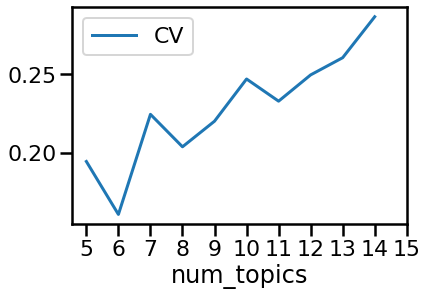

In [39]:
#Visualize the trend of the c_v score
import matplotlib.pyplot as plt
sns.set_context('poster')
scores = pd.DataFrame(coherence_values, columns=['num_topics','CV'])
scores.plot.line(x='num_topics', y='CV', xticks=range(5,16));

In [40]:
#Bsed on the c_v score results a number of topics equal to 9 seems to be appropriate. 
#Although higher number of toopics still have high c_score values they might be hard to interpret and not so precise

num_topics = 10
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics,
                     corpus=model_corpus,
                     id2word=dictionary_big, 
                     workers=min(10, multiprocessing.cpu_count()-1),
                     passes=num_passes, 
                     chunksize=chunk_size, 
                     alpha=0.5)
    
print("done in {}".format(time.time()-start), flush=True)

topic_corpus = model[model_corpus]
#topic_corpus[0]

#Print the topics in a ore readable format transofmring them using RegEx
topic_sep = re.compile(r"0\.[0-9]{3}\*") 
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

4219.1
fitting model
done in 32.6003532409668
1 "ask", "let", "way", "be", "set"
2 "say", "hermione", "ron", "potter", "whisper"
3 "find", "good", "mean", "long", "sirius"
4 "come", "right", "hear", "word", "understand"
5 "know", "s", "happen", "dumbledore", "remember"
6 "get", "try", "think", "voldemort", "kill"
7 "snape", "turn", "hagrid", "shout", "death_eater"
8 "look", "tell", "want", "feel", "sit"
9 "eye", "thing", "speak", "boy", "sure"
10 "go", "face", "talk", "neville", "bit"


#### 2.5.2- DYNAMIC TOPIC MODELING -- LdaSeqModel
<a id="dynamic"></a> 

In [41]:
'''Analyzing the changes of three topics btetween the two halves of Harry Potter 1 and the two halves of Harry Potter 7
'''

#Create an object toklist_17 containing the tokens for Book1 and Book 7 together
toklist_17 = corpustot.loc[corpustot['Book'].isin(['Harry Potter 1','Harry Potter 7'])]['Tokens'].to_list() 
    #List of the tokens for book1 and book 7 (ordered) -- len(toklist17 = 21618)
    #HP 1 Has 6647 rows of tokens
    #HP 7 has 14971 rows of tokens  
    
#A before, we consider bigrams 
phrases_17 = Phrases(toklist_17)
bigram_17 = Phraser(phrases_17) 
bigrams_17 = list(bigram_17[toklist_17]) 
print(len(bigrams_17))

21618


In [42]:
#Create the relevant corpus and build up a dictionary 
sent_big_17 = pd.Series(bigrams_17) 
dictionary_big_17 = Dictionary(sent_big_17)
dictionary_big_17.filter_extremes(no_below=100, no_above=0.1) 
print(dictionary_big_17, flush=True)

ldacorpus_17 = [dictionary_big_17.doc2bow(text) for text in sent_big_17]
tfidfmodel_17 = TfidfModel(ldacorpus_17)
model_corpus_17 = tfidfmodel[ldacorpus_17]

print(sent_big_17[0])
print(ldacorpus_17[0])
print(model_corpus_17[0])

time_slice = [3323,3324,7485,7486] 
                    #Time slots I am considering 
                    #First time slot represents the first half of Book1
                    #Second time slot represents the second half of Book1
                    #Third time slot represents the first half of Book7
                    #Fourth time slot represents the second half of Book7

                    
#Run the LDA Seq model that allows to track the dynamics of the topics. 
ldaseq = ldaseqmodel.LdaSeqModel(corpus=ldacorpus_17, 
                                 id2word=dictionary_big_17, 
                                 time_slice=time_slice, 
                                 num_topics=3)

Dictionary(169 unique tokens: ['potter', 'hold', 'people', 'call', 'large']...)
['harry', 'potter', 'sorcerer_stone', 'mr_mrs', 'dursley', 'number', 'privet_drive', 'proud', 'perfectly', 'normal', 'thank']
[(0, 1)]
[(0, 1.0)]


C:\Users\Ospite\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\Ospite\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\Users\Ospite\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\Ospite\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\Ospite\anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_ol

In [43]:
#Look at the three different topics at time 0 (corresponding to the first book)
ldaseq.print_topics(time=0)  

[[('know', 0.09627201415692942),
  ('think', 0.0663496567614442),
  ('dumbledore', 0.05778358134532566),
  ('go', 0.050475253544914264),
  ('want', 0.03776181382400134),
  ('potter', 0.027738407556378648),
  ('snape', 0.026772337931377607),
  ('try', 0.024666033982954628),
  ('s', 0.023570684779183625),
  ('good', 0.023509679366478072),
  ('find', 0.02322222358714224),
  ('hear', 0.021798266023255904),
  ('thing', 0.019581639647362148),
  ('tell', 0.018401539802319254),
  ('need', 0.01774743155353473),
  ('happen', 0.01730168685747726),
  ('voice', 0.017190910533684503),
  ('mean', 0.016394343675550278),
  ('sure', 0.014257332346917595),
  ('kill', 0.01366670210229513)],
 [('come', 0.039047251420610336),
  ('hagrid', 0.038687698362466966),
  ('time', 0.03331034047075859),
  ('voldemort', 0.031921654291614546),
  ('get', 0.02952708565096539),
  ('tell', 0.02477847713490108),
  ('wand', 0.021633494316670224),
  ('take', 0.020758263429933397),
  ('leave', 0.02066942581392339),
  ('right',

In [44]:
ldaseq.print_topics(time=1)  #Look at the three different topics at time 1 (corresponding to book7)

[[('know', 0.09626027939377164),
  ('think', 0.07183937442630446),
  ('dumbledore', 0.05810208549853643),
  ('go', 0.04991492515176747),
  ('want', 0.03793866296707189),
  ('snape', 0.030335112469255368),
  ('potter', 0.025236627881838274),
  ('try', 0.02438284775468517),
  ('s', 0.02380046921329028),
  ('good', 0.0231473229422665),
  ('find', 0.023040946989865307),
  ('hear', 0.02085469759165634),
  ('thing', 0.019404319557776),
  ('tell', 0.018257266455565246),
  ('need', 0.017886028237782965),
  ('happen', 0.017638576159325688),
  ('voice', 0.017205802227630695),
  ('mean', 0.016352278511744544),
  ('sure', 0.014232522127069363),
  ('kill', 0.013707225060361565)],
 [('come', 0.03935430441280961),
  ('hagrid', 0.03740113081132577),
  ('time', 0.03404741838421339),
  ('voldemort', 0.0334381321369181),
  ('get', 0.02931415311432008),
  ('tell', 0.02494909478225923),
  ('wand', 0.02218312873279309),
  ('right', 0.021246283887765154),
  ('take', 0.021101173111727205),
  ('leave', 0.02081

In [45]:
#ldaseq.print_topic_times(topic=0) # Evolution of 1st topic along the four time slots
ldaseq.print_topic_times(topic=1) # Evolution of 2nd topic along the four time slots
#ldaseq.print_topic_times(topic=2) # Evolution of 3rd topic along the four time slots

#There can be seen some sligth changes along the periods
#The relative weight of some terms changes in particolar between the first two slots (represetning book1) and the second two slots (representing book7)

[[('come', 0.039047251420610336),
  ('hagrid', 0.038687698362466966),
  ('time', 0.03331034047075859),
  ('voldemort', 0.031921654291614546),
  ('get', 0.02952708565096539),
  ('tell', 0.02477847713490108),
  ('wand', 0.021633494316670224),
  ('take', 0.020758263429933397),
  ('leave', 0.02066942581392339),
  ('right', 0.020667734014613616),
  ('dudley', 0.01662074235848632),
  ('uncle_vernon', 0.016513193099819853),
  ('old', 0.016118357436137275),
  ('house', 0.01611415622192008),
  ('wizard', 0.014141595456724571),
  ('people', 0.013804216219808471),
  ('place', 0.013675676453536937),
  ('day', 0.013496897810367812),
  ('hogwart', 0.013361530814927977),
  ('sit', 0.013352518310363574)],
 [('come', 0.03935430441280961),
  ('hagrid', 0.03740113081132577),
  ('time', 0.03404741838421339),
  ('voldemort', 0.0334381321369181),
  ('get', 0.02931415311432008),
  ('tell', 0.02494909478225923),
  ('wand', 0.02218312873279309),
  ('right', 0.021246283887765154),
  ('take', 0.02110117311172720

In [46]:
doc = ldaseq.doc_topics(500) #Compare the composition of different documents(=sentences)
                                #Choose one document that belongs to Book1 i.e doc(500)
print(doc)

[0.00970874 0.98058252 0.00970874]


In [47]:
doc = ldaseq.doc_topics(7000) #Look at the topic composition of a document 
                                #Choose one document that belongs to Book1 i.e doc(500)
print (doc)

[0.99014778 0.00492611 0.00492611]


### 2.6- MATRIX FACTORIZATION
<a id="matrix"></a> 

In [48]:
#NMF FACTORIZATION
documents = corpustot['Instances'].to_list() #Defining the input which is a List of all the instances 

tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.001, max_df=0.75, stop_words='english', sublinear_tf=True)   
X = tfidf_vectorizer.fit_transform(documents)
tfidf_vectorizer.get_feature_names()
print(X.shape)

(84382, 1066)


In [49]:
k = 10
nmf = NMF(n_components=k, init='nndsvd', random_state=0)
%time W = nmf.fit_transform(X) 
H = nmf.components_ 
print(W.shape, H.shape)

Wall time: 1.37 s
(84382, 10) (10, 1066)


In [50]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

In [51]:
terms = tfidf_vectorizer.get_feature_names()
sorted(show_topics(H, terms)) #Show the topics obtained using NMF Factorization 

['come, come say, time, voice, hagrid',
 'dumbledore, say dumbledore, professor, ask, snape',
 'harry, say harry, harry say, feel, harry look',
 'hermione, say hermione, ron hermione, ask, whisper',
 'know, know say, harry know, want, mean',
 'look, harry look, face, hagrid, hermione look',
 'ron, say ron, ron hermione, harry ron, ron look',
 'say, say harry, say hermione, voice, say ron',
 'tell, want, hagrid, time, happen',
 'think, harry think, think say, try, right']

In [52]:
#SVD MATRIX FACTORIZATION
svd = TruncatedSVD(n_components=k) 
%time U = svd.fit_transform(X) 
S = svd.singular_values_
V = svd.components_ 
print(U.shape, S.shape, V.shape)
sorted(show_topics(V, terms)) #Show the topics obtained with SVD Factorization

Wall time: 322 ms
(84382, 10) (10,) (10, 1066)


['come, dumbledore, tell, say dumbledore, want',
 'dumbledore, tell, say dumbledore, professor, snape',
 'harry, look, harry look, feel, ask',
 'know, look, hermione, ron, think',
 'know, say harry, say, think, know say',
 'look, say, say harry, dumbledore, harry look',
 'ron, say ron, come, dumbledore, tell',
 'say, harry, say harry, hermione, ron',
 'tell, want, hagrid, say harry, hear',
 'think, dumbledore, come, tell, harry think']

### 2.7- CLUSTERING 
<a id="clustering"></a> 

In [53]:
k = 4 #Number of clusters chosen assuming each pair of books could be around one cluster 
%time X2 = TruncatedSVD(n_components=800).fit_transform(X)
agg = AgglomerativeClustering(n_clusters=k)

Wall time: 20.9 s


In [54]:
sample = np.random.choice(len(X2), replace=False, size=3000)
%time agg_sample = agg.fit_predict(X2[sample])

Wall time: 3.77 s


In [55]:
# let's get the centroid/average of each cluster
centroids = np.array([X2[sample][agg_sample == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(4, 800)


In [56]:
# initialize k-means with the agglomerative clusters
km = KMeans(n_clusters=k, n_jobs=-1, init=centroids)
%time km.fit(X2)

C:\Users\Ospite\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  """Entry point for launching an IPython kernel.


Wall time: 5.73 s


KMeans(algorithm='auto', copy_x=True,
       init=array([[ 6.90801832e-02,  4.10209474e-03,  3.67180559e-02, ...,
        -1.31981204e-04, -8.50863738e-06,  3.73864714e-04],
       [ 2.10987895e-01, -2.17184867e-02,  1.46386873e-01, ...,
         1.01765284e-03, -5.26007580e-04, -3.89395186e-04],
       [ 6.09974157e-01,  7.14112743e-01, -1.17147030e-01, ...,
        -1.39547325e-03,  1.29722519e-03, -1.91930197e-03],
       [ 6.63719320e-01, -2.82102413e-01, -1.96114691e-01, ...,
         5.45339208e-04,  5.76688939e-04,  3.93030833e-04]]),
       max_iter=300, n_clusters=4, n_init=10, n_jobs=-1,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

3 0.02032963551482158
4 0.013286057006114078
5 0.012447236403603392
6 0.0124225007392972
7 0.011676878578896535
8 0.009472315897981427
9 0.01118054107405344
10 0.011725029584988144
11 0.009742864731423282
12 0.00816695121380847
13 0.008564220002052356
14 0.010036549860225015


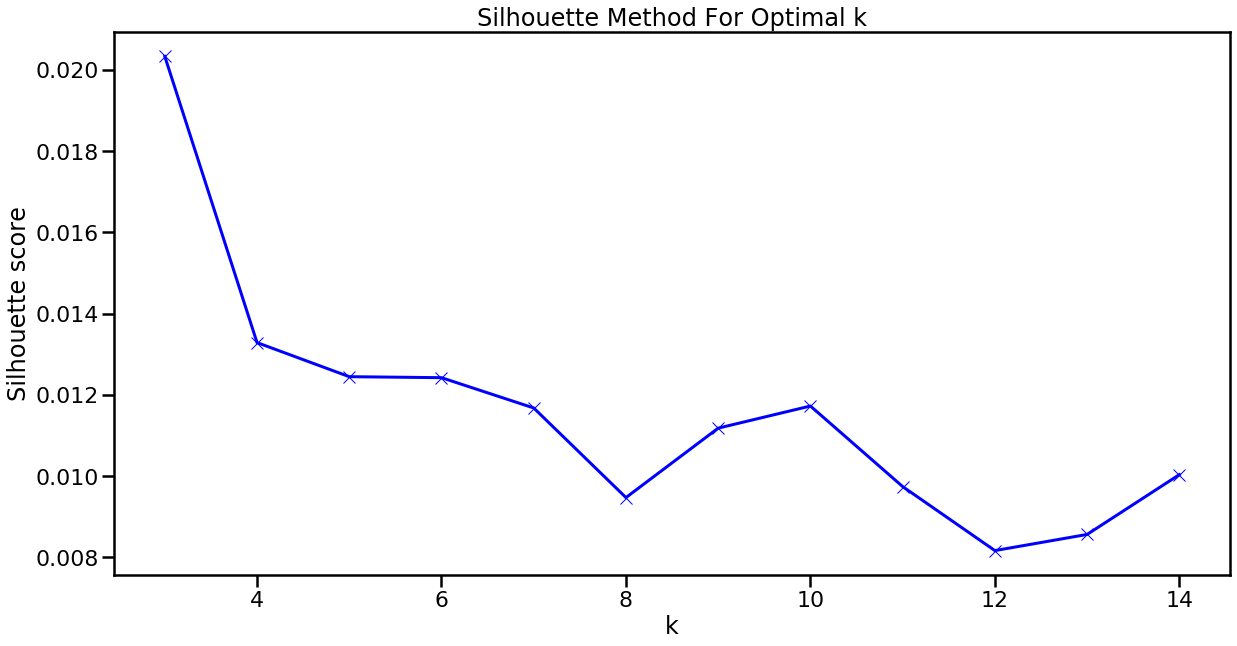

In [57]:
silhouettes = [] #Evaluate the silhouette score for different numbers of clusters and look at the trend 
K = range(3,15)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
#     agg_centroids = np.array([X2[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) 
#                            for k in range(c)])

#     kmeans_clustering = KMeans(n_clusters=c, n_jobs=-1, init=agg_centroids)
#     kmeans_ids = kmeans_clustering.fit_predict(X2)
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

#4 Topics seems to be appropriate 

## 3. Visualization 
<a id="visualization"></a> 

### 3.1- WORD EMBEDDINGS VISUALIZATION
<a id="word-visua"></a> 

In [86]:
'''
T-sne to visualize word embeddings 
'''

def words_space_tsne(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE of a word,
    its list of most similar words, and a list of random words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    close_words = model.wv.most_similar(positive = [word]) #Get the most similar words 
    
    for wrd_score in close_words: 
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    for wrd in list_names: #Represent the list of random words 
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    reduc = PCA(n_components=19).fit_transform(arrays) #Reduce dimensionality using PCA
    np.set_printoptions(suppress=True) #tsne representation
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    p1 = sns.regplot(data=df, x="x",y="y", fit_reg=False, marker="o", scatter_kws={'s': 40,'facecolors': df['color']})
    
    for line in range(0, df.shape[0]): #Add labels 
         p1.text(df["x"][line],
                 df['y'][line],'  ' + df["words"][line].title(),horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

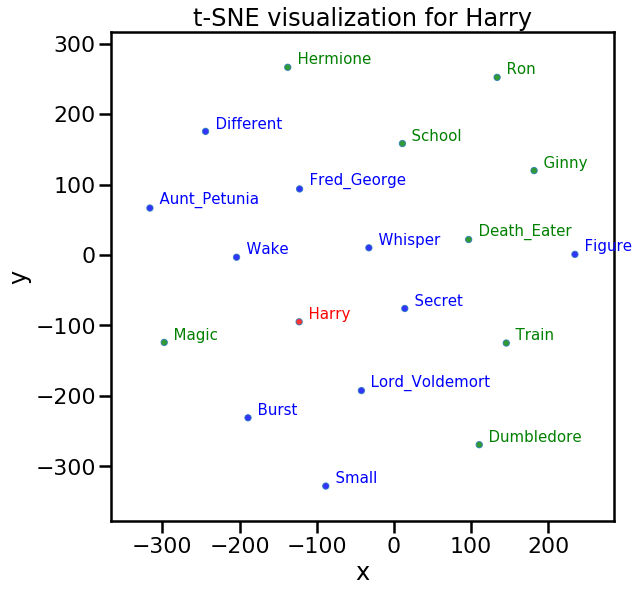

In [87]:
words_space_tsne(w2v_model, 'harry', ['magic', 'school','death_eater','ginny', 'train', 'hermione', 'ron','dumbledore'])

### 3.2- TSNE WORD2VEC VISUALIZATION
<a id="tsne"></a> 

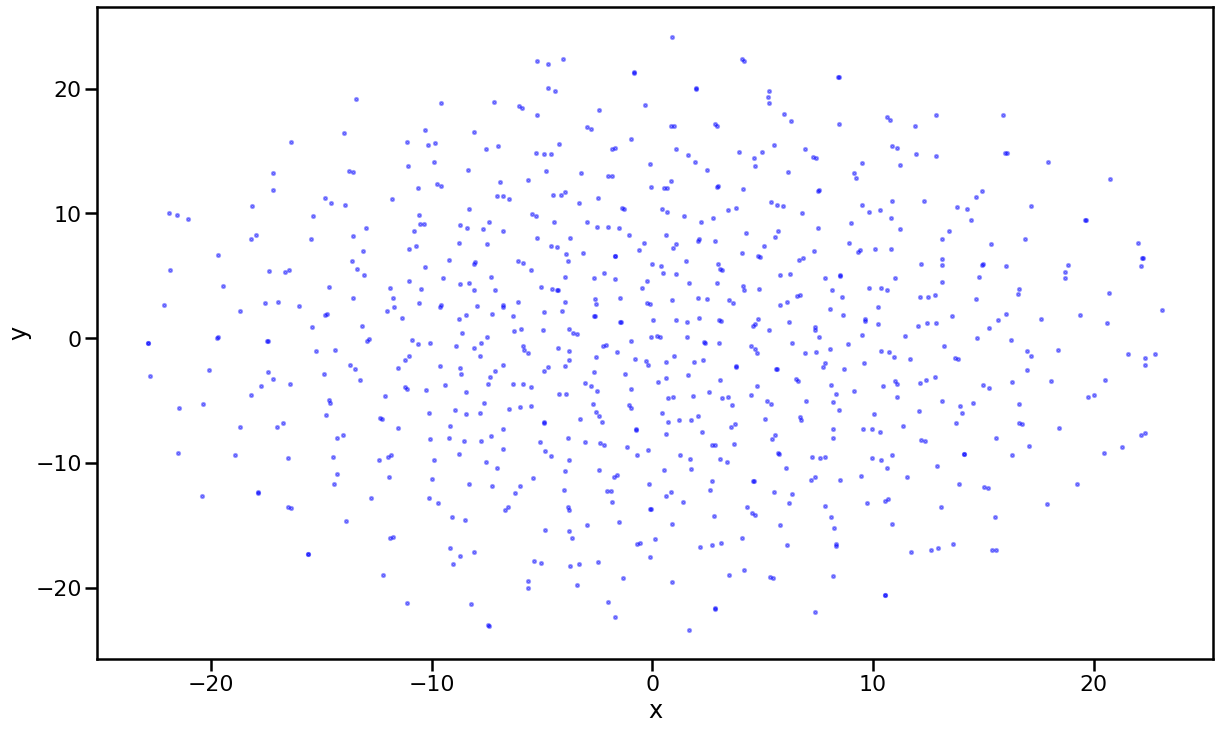

In [88]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = w2v_model.wv.vectors
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[w2v_model.wv.vocab[word].index])
            for word in w2v_model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
sns.set_context("poster")
points.plot.scatter("x", "y", s=10,c='blue',figsize=(20, 12),alpha=0.4)

### 3.3- WORD2VEC FOR BOOK1 AND BOOK7 REPRESENTATION
<a id="book1book7"></a> 

In [89]:
def tsne_scatter(model):  
 
    labels = []  
    tokens = []  

    for word in model.wv.vocab:  
        tokens.append(model.wv.__getitem__(word))  
        labels.append(word)  

    tsne_model = TSNE(perplexity=15, n_components=2, init='pca', n_iter=2500)  
    new_values = tsne_model.fit_transform(tokens)  

    x = []  
    y = []  
    for value in new_values:  
        x.append(value[0])  
        y.append(value[1])  

    plt.figure(figsize=(20, 20))   
    for i in range(len(x)):  
        plt.scatter(x[i],y[i],alpha = 0.4)  
        plt.annotate(labels[i],  xy=(x[i], y[i]),  xytext=(5, 2),  textcoords='offset points',  ha='left',  va='top',fontsize = 12)  
    plt.title('Visualization {}'.format(model),fontsize=20)
    plt.show()

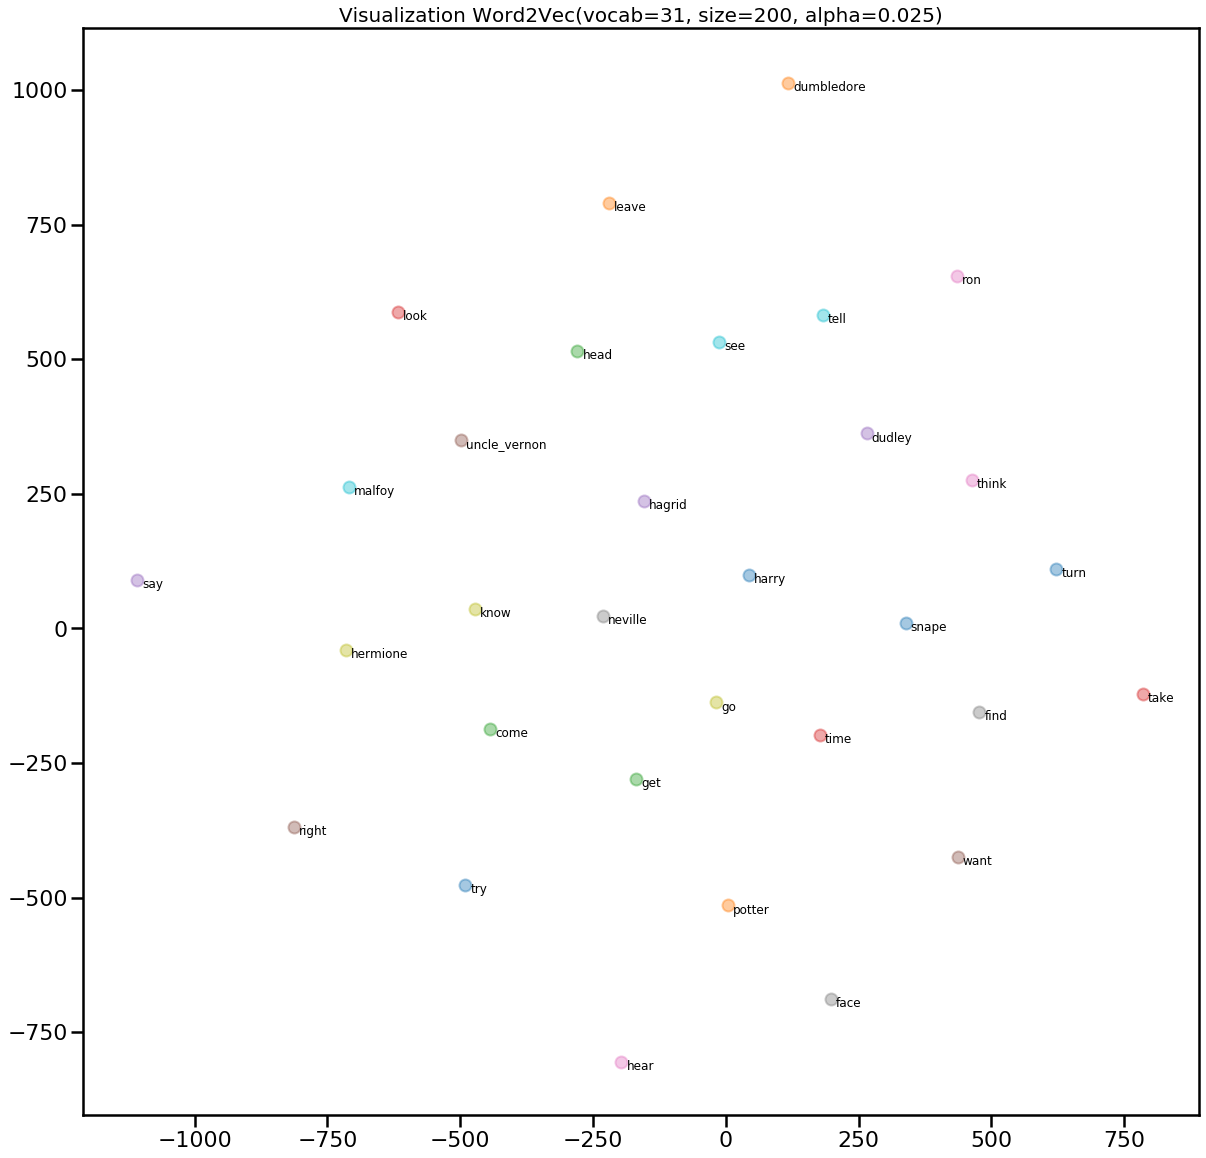

In [90]:
tsne_scatter(w2v_model_1)

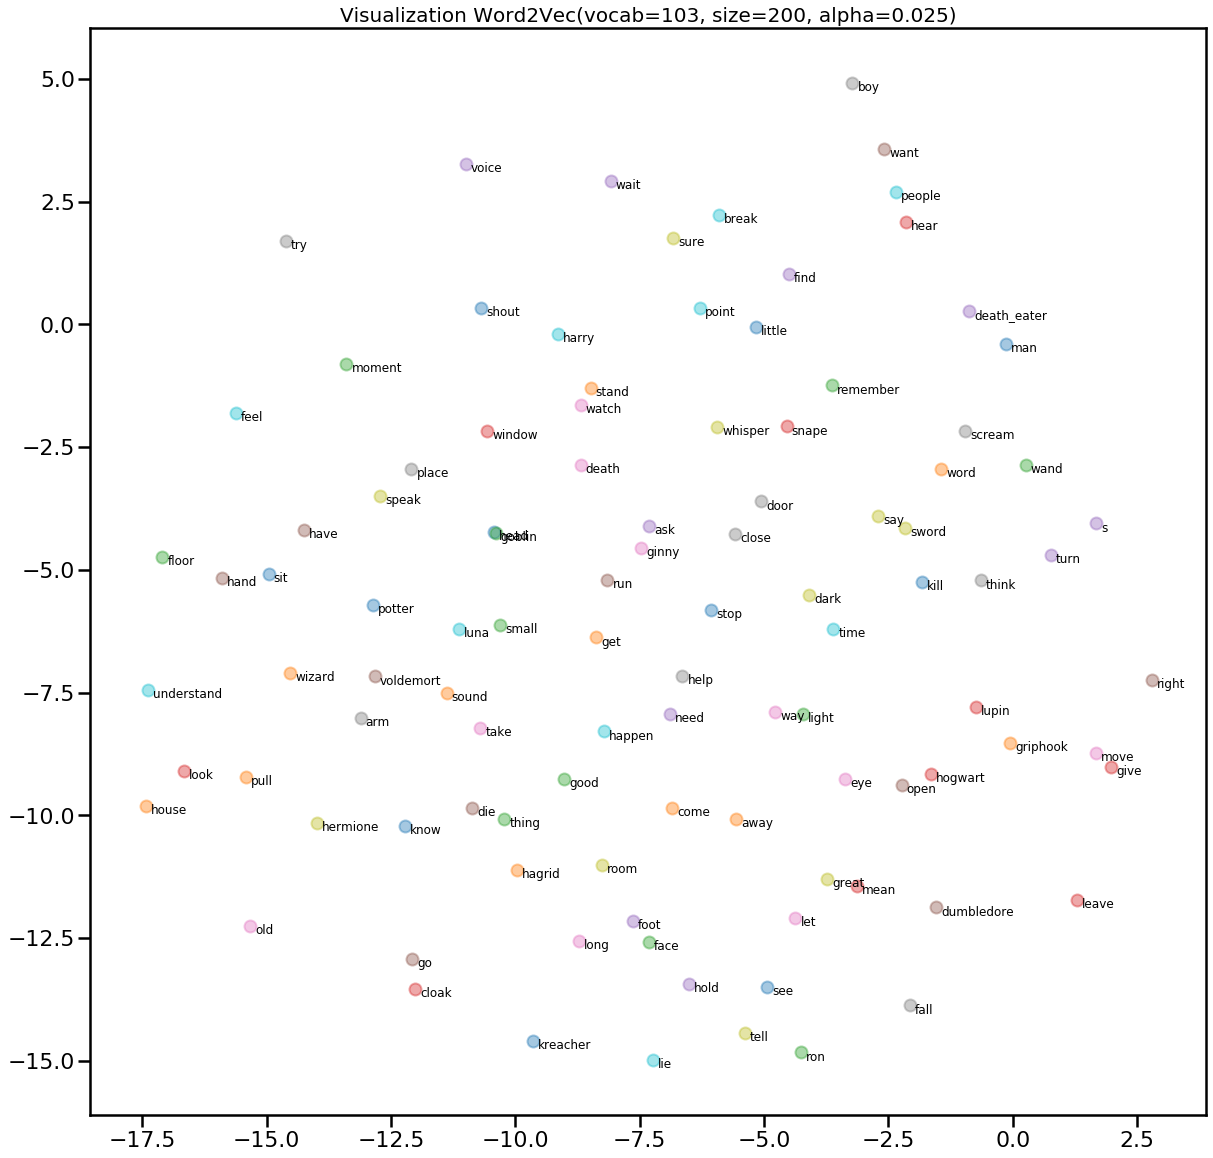

In [91]:
tsne_scatter(w2v_model_7)

### 3.4- PCA WORD EMBEDDINGS VISUALIZATION
<a id="pcavisua"></a> 

In [92]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model.wv.__getitem__(w) for w in words])
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r',alpha=0.4)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.001, y+0.001, word, horizontalalignment='left',verticalalignment='center', fontsize = 12)

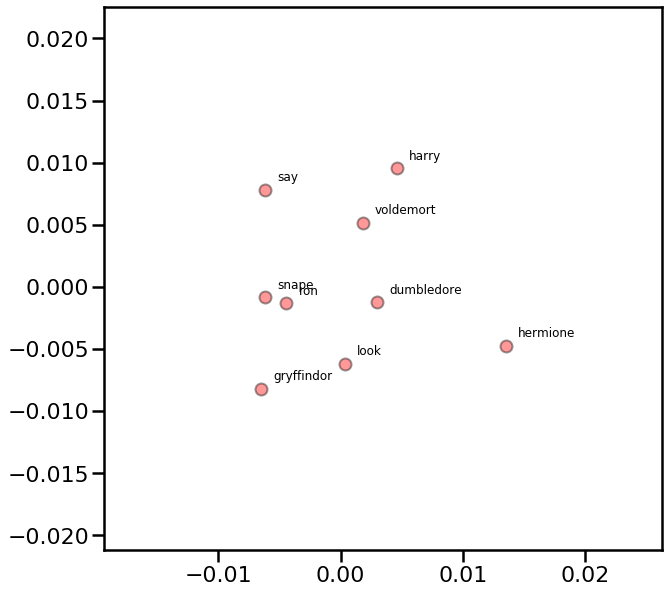

In [93]:
#Plot PCA word embeddings visualization for a list of words
#For instance the list ['harry','ron','hermione','dumbledore','snape','voldemort','say','look','gryffindor'] which is quite small and contains come relevant terms 
#We could have defined whatever list of words 
#We could also plot the whole dictionary of words (but it becomes not readable)
# To plot the whole vacabulary use words = w2v_model.wv.vocab.keys()

words =['harry','ron','hermione','dumbledore','snape','voldemort','say','look','gryffindor']
display_pca_scatterplot(w2v_model, words)

##### 3.5- UNIGRAMS TF-IDF-TFIDF VISUALIZATION scaled by TF
<a id="tf-scaled"></a> 

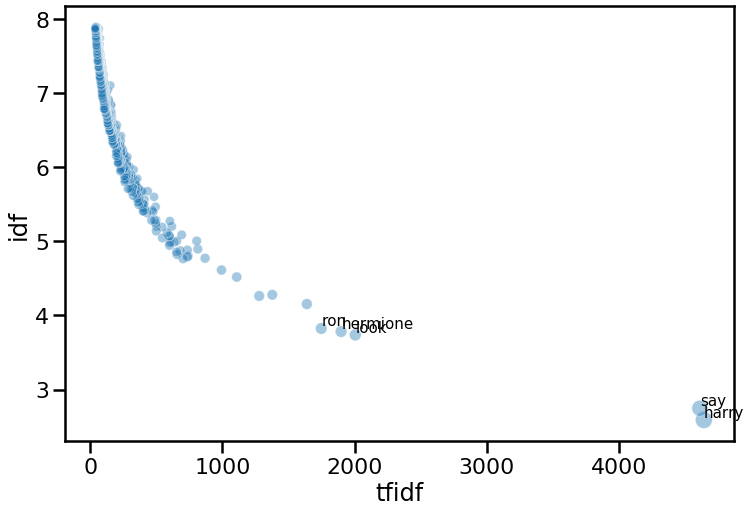

In [94]:
%matplotlib inline
plt.figure(figsize=(12,8))
sns.set_context('poster')
plot = sns.scatterplot('tfidf','idf',size='tf', data =uni_df,legend= False,alpha=0.4)

indeces = [381,718,497,395,710] 
for index in indeces:
     plot.text(uni_df.tfidf[index]+0.8, uni_df.idf[index]+0.2,uni_df.word[index], horizontalalignment='left', verticalalignment='top',fontsize=15)

### 3.6- BIGRAMS TF-IDF-TFIDF VISUALIZATION scaled by TF
<a id="bigrams-scaled"></a> 

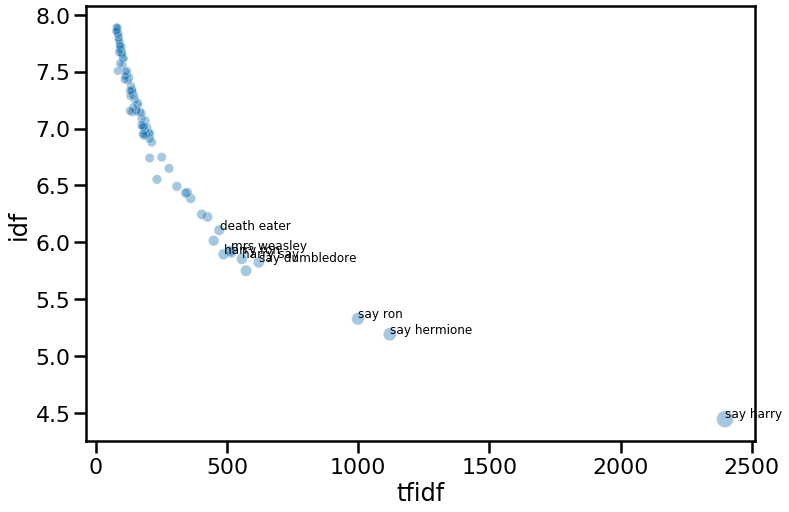

In [95]:
%matplotlib inline
sns.set_context('poster')
plt.figure(figsize=(12,8))
plot = sns.scatterplot('tfidf','idf',size ='tf', data =bi_df,legend= False,alpha=0.4)

indeces = [75,76,84,69,28,50,27,10]
for index in indeces:
     plot.text(bi_df.tfidf[index]+1.2, bi_df.idf[index]+0.1, bi_df.word[index], horizontalalignment='left', verticalalignment='top',fontsize=12)

##### 3.7- HARRY - RON - HERMIONE OCCURENCIES  VISUALIZATION
<a id="harry-ron-occ"></a> 

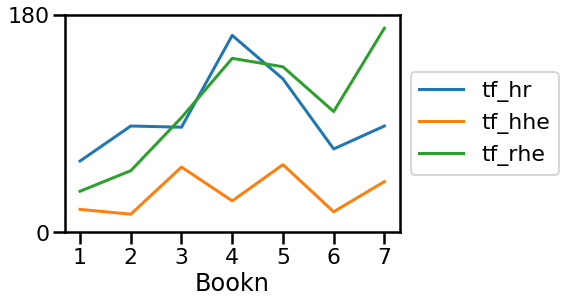

In [96]:
HR_HHe_RHe.plot.line(xticks=range(0,7), yticks = (0,180))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

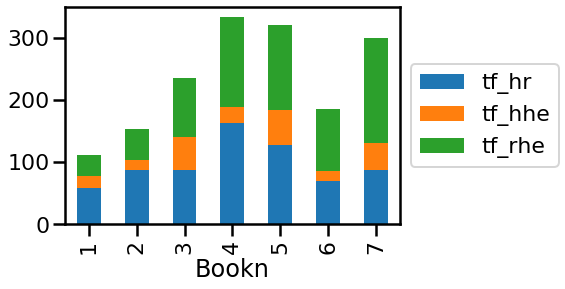

In [97]:
HR_HHe_RHe.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

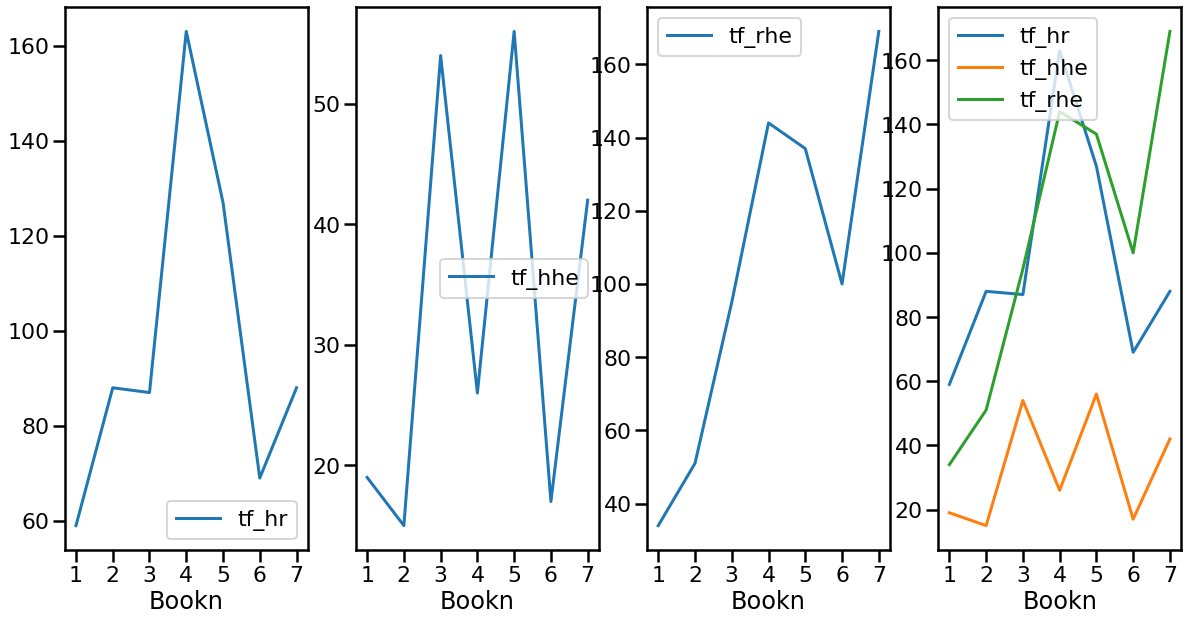

In [98]:
#Plot separately the three frequencies 
HR_HHe_RHe = HR_HHe.join(RHesum.add_suffix('_rhe'), on='Bookn')
HR_HHe_RHe = HR_HHe_RHe[['tf_hr', 'tf_hhe','tf_rhe']]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
HR_HHe_RHe.plot.line( y='tf_hr', ax=ax[0], xticks=range(0,7)); 
HR_HHe_RHe.plot.line( y='tf_hhe', ax=ax[1], xticks=range(0,7));
HR_HHe_RHe.plot.line( y='tf_rhe', ax=ax[2], xticks=range(0,7));
HR_HHe_RHe.plot.line( y=['tf_hr','tf_hhe','tf_rhe'], ax=ax[3], xticks=range(0,7))

### 3.8- TOPIC MODELING VISUALIZATION
<a id="topic-visua"></a> 

In [99]:
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=model, corpus = model_corpus,dictionary=dictionary_big)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

#See the 'Topic Modeling Visualization' png file in the zip folder

In [100]:
'''
Visualizing the distribution of topics across the different groups
'''

target_category = 'Book'
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(sent_big))]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['HP'] = corpustot[target_category]

In [101]:
topic_distros

,"ask, let","say, hermione","find, good","come, right","know, s","get, try","snape, turn","look, tell","eye, thing","go, face",HP
0,0.066130,0.135373,0.126666,0.120853,0.111284,0.066023,0.066352,0.175277,0.066086,0.065957,Harry Potter 1
1,0.071351,0.073067,0.072891,0.262690,0.081145,0.074291,0.072242,0.148818,0.072874,0.070632,Harry Potter 1
2,0.083788,0.083552,0.083542,0.083540,0.083753,0.083583,0.085822,0.243931,0.083789,0.084700,Harry Potter 1
3,0.149946,0.076653,0.072105,0.072418,0.071829,0.098246,0.215838,0.070735,0.082795,0.089435,Harry Potter 1
4,0.075147,0.067258,0.072246,0.188412,0.064268,0.069662,0.176436,0.065087,0.144369,0.077115,Harry Potter 1
...,...,...,...,...,...,...,...,...,...,...,...
84377,0.084703,0.079914,0.081141,0.082134,0.081162,0.082689,0.258442,0.079979,0.083551,0.086285,Harry Potter 7
84378,0.136298,0.079478,0.079713,0.078912,0.078635,0.083092,0.079182,0.225582,0.079938,0.079169,Harry Potter 7
84379,0.164854,0.071252,0.073456,0.145869,0.071737,0.072475,0.074546,0.177248,0.074310,0.074253,Harry Potter 7
84380,0.083528,0.083452,0.083444,0.083499,0.247662,0.084197,0.083503,0.083564,0.083582,0.083570,Harry Potter 7


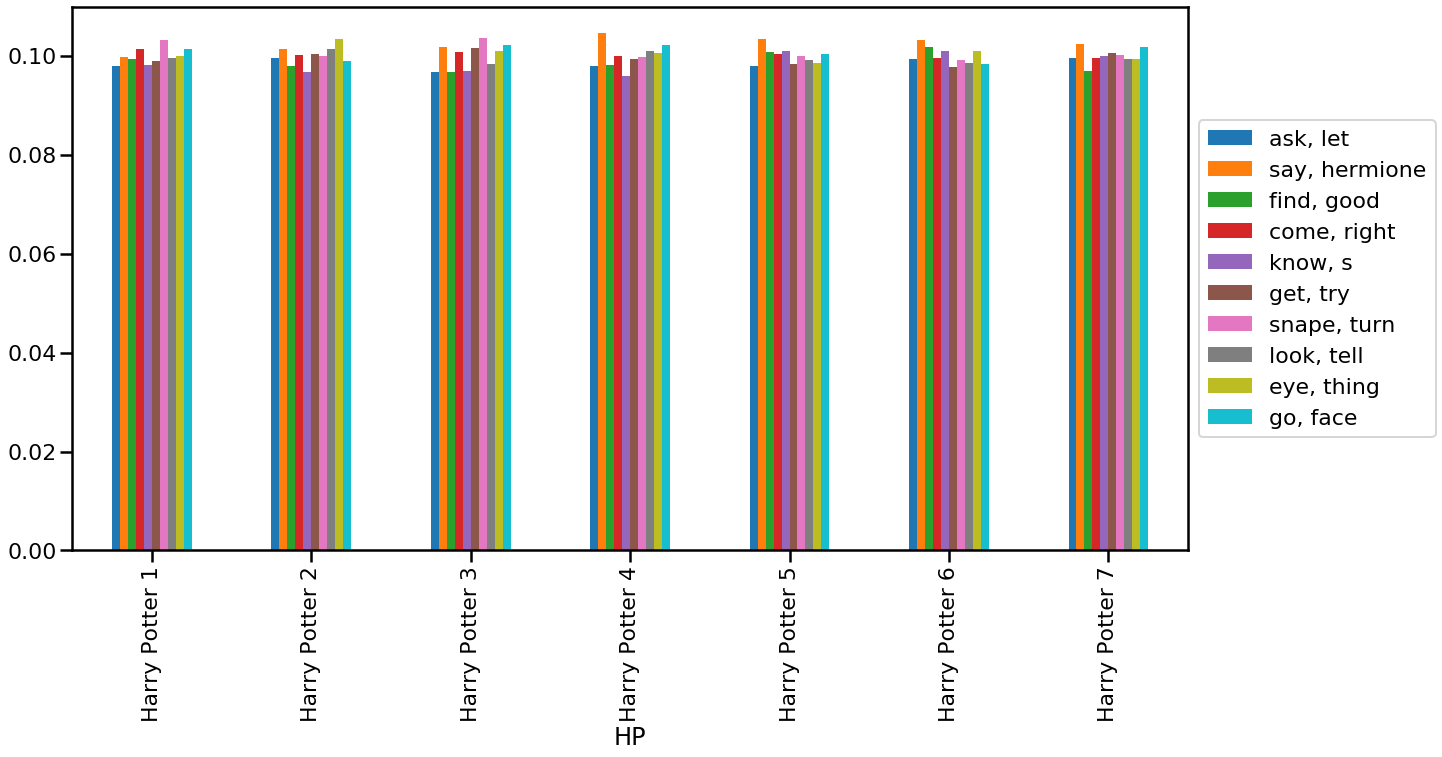

In [102]:
import matplotlib.pyplot as plt 
import seaborn

seaborn.set_context('poster') 
fig, ax = plt.subplots(figsize=(20, 10)) 
aggregate_by_category = topic_distros[topic_distros.HP.isin('Harry Potter 1,Harry Potter 2,Harry Potter 3,Harry Potter 4,Harry Potter 5,Harry Potter 6,Harry Potter 7'.split(','))]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.HP).mean()
aggregate_by_category[descriptors].plot.bar(ax=ax);
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

### 3.9- CLUSTERING VISUALIZATION 
<a id="clust-visua"></a> 

In [103]:
sns.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph -- 10x10 image (square image)
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied (add a columns for labels)
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('Spectral') # choose the color palette ; we can choose the color map
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

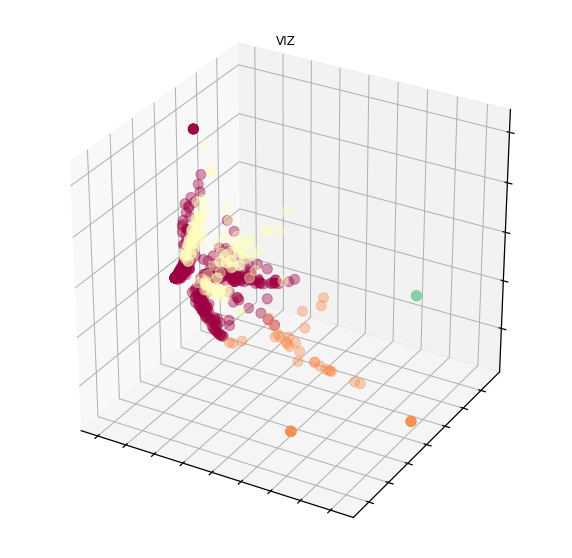

In [104]:
plot_sample = np.random.choice(len(X2), replace=False, size=1000)
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

In [105]:
#SVD and NMF VISUALIZATION
documents = corpustot['Instances'].to_list() #Defining the input which is a List of all the instances 

tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.001, max_df=0.75, stop_words='english', sublinear_tf=True)   
X = tfidf_vectorizer.fit_transform(documents)
X.shape


low_dim_svd = TruncatedSVD(n_components=2)
low_dim_nmf = NMF(n_components=2, init='nndsvd')

Z = X[:60000]
categories = corpustot.Book[:60000]

low_dim_U = low_dim_svd.fit_transform(Z)
low_dim_W = low_dim_nmf.fit_transform(Z)

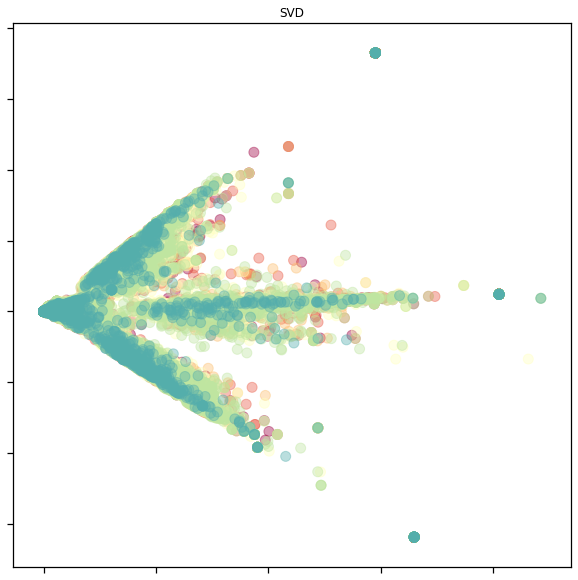

In [106]:
plot_vectors(low_dim_U, title='SVD', labels=categories, dimensions=2)

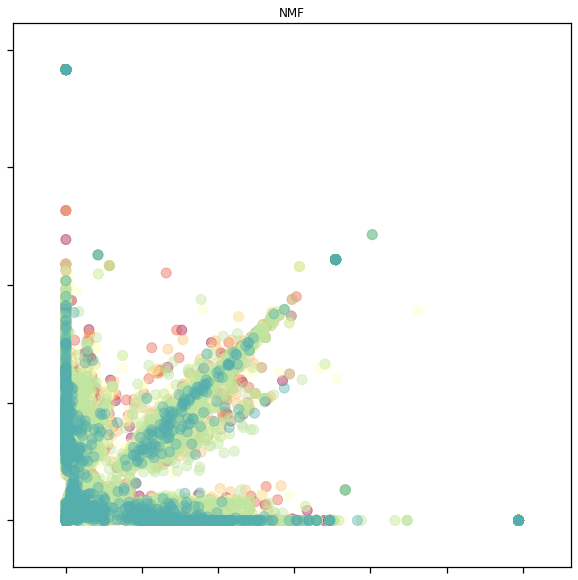

In [107]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=2)